# MNIST & CIFAR-10 CNNs with Dropout — Reproducing Srivastava et al. (2014)

This notebook implements CNNs with Dropout, matching the paper's MNIST setup, and extends to CIFAR-10. It includes:

- GPU support (if available)
- Training metrics (loss & accuracy) and plots
- 2D visualizations and an interactive 3D surface plot using Plotly
- Max-norm constraint, SGD with high momentum, and paper-like hyperparameters

**Local copy of the paper (uploaded):** `/mnt/data/srivastava14a.pdf`

Download the notebook at the end of the run.


In [9]:
# Standard imports and device setup
import os
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "vscode"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [2]:

# Data loaders (MNIST and CIFAR-10 optional)
def get_mnist_loaders(batch_size=100):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))])
    train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader

def get_cifar10_loaders(batch_size=128):
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),(0.247,0.243,0.261))
    ])
    train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, test_loader

# Quick smoke-load to ensure datasets download if running
mnist_train_loader, mnist_test_loader = get_mnist_loaders(batch_size=256)
print("MNIST loaders ready. Example batch shape:")
xb, yb = next(iter(mnist_train_loader))
print(xb.shape, yb.shape)


MNIST loaders ready. Example batch shape:


/Users/akshaykumar/Documents/Projects/IUKUK/paper-implementation/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning:

'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.



torch.Size([256, 1, 28, 28]) torch.Size([256])


In [3]:

# Models
class MNIST_CNN(nn.Module):
    """Architecture matching the notebook earlier and the style used in the paper's experiments:
       Conv(5x5,32) -> ReLU -> Pool -> Conv(5x5,64) -> ReLU -> Pool -> FC(1024) -> Dropout(0.5) -> Softmax
    """
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)   # 28->24
        self.pool  = nn.MaxPool2d(2,2)                 # 24->12
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)  # 12->8
        # after second pool: 8->4 (since pool reduces by factor 2)
        self.fc1 = nn.Linear(64*4*4, 1024)
        self.dropout = nn.Dropout(dropout_p)          # paper used p=0.5 for hidden layers
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class CIFAR_CNN(nn.Module):
    """A slightly larger convnet for CIFAR-10 experiments (dropout applied before final FCs)."""
    def __init__(self, dropout_p=0.5):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1), nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,padding=1), nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1), nn.ReLU(),
            nn.MaxPool2d(2,2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*8*8, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [4]:

# Max-norm projection for incoming weights of a Linear/Conv layer
def apply_max_norm(model, max_val=3.0):
    with torch.no_grad():
        for name, param in model.named_parameters():
            if 'weight' in name:
                if param.dim() >= 2:
                    view = param.view(param.size(0), -1)
                    norms = view.norm(2, dim=1, keepdim=True)
                    desired = torch.clamp(norms, max=max_val)
                    view *= (desired / (1e-8 + norms))
                    param.copy_(view.view(param.size()))
    return

# Training and evaluation functions
def train_one_epoch(model, loader, optimizer, criterion, device, max_norm=None):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        if max_norm:
            apply_max_norm(model, max_val=max_norm)
        running_loss += loss.item() * xb.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)
    return running_loss/total, correct/total

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            running_loss += loss.item() * xb.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += xb.size(0)
    return running_loss/total, correct/total


In [5]:

# High-level training script with metrics recording and plotting utilities

def fit_model(model, train_loader, test_loader, epochs=10, lr=0.1, momentum=0.95, max_norm=3.0, save_path=None):
    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss()
    train_losses, train_accs = [], []
    test_losses, test_accs = [], []
    for ep in range(1, epochs+1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, max_norm=max_norm)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        train_losses.append(train_loss); train_accs.append(train_acc)
        test_losses.append(test_loss); test_accs.append(test_acc)
        print(f"Epoch {ep}/{epochs}  Train loss {train_loss:.4f} acc {train_acc:.4f}  |  Test loss {test_loss:.4f} acc {test_acc:.4f}")
        if save_path:
            torch.save({'epoch': ep, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict()}, save_path)
    history = dict(train_loss=train_losses, train_acc=train_accs, test_loss=test_losses, test_acc=test_accs)
    return model, history

def plot_history(history):
    epochs = len(history['train_loss'])
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(range(1,epochs+1), history['train_loss'], label='train loss')
    plt.plot(range(1,epochs+1), history['test_loss'], label='test loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(range(1,epochs+1), history['train_acc'], label='train acc')
    plt.plot(range(1,epochs+1), history['test_acc'], label='test acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()
    plt.show()


In [6]:

# Visualization utilities: 2D imshow and interactive Plotly 3D surface for a single image

def show_sample_2d(img_tensor, label=None):
    img = img_tensor.cpu().numpy()
    if img.shape[0]==1:
        img = img[0]
    plt.figure(figsize=(3,3))
    plt.imshow(img, cmap='gray')
    if label is not None:
        plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()

def show_sample_3d_plotly(img_tensor, title='3D surface'):
    img = img_tensor.cpu().numpy()
    if img.shape[0]==1:
        img = img[0]
    z = img
    x = np.arange(z.shape[1])
    y = np.arange(z.shape[0])
    fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
    fig.update_layout(title=title, autosize=False, width=600, height=600)
    fig.show()


MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)
Epoch 1/3  Train loss 0.2650 acc 0.9212  |  Test loss 0.0692 acc 0.9790
Epoch 1/3  Train loss 0.2650 acc 0.9212  |  Test loss 0.0692 acc 0.9790
Epoch 2/3  Train loss 0.0814 acc 0.9771  |  Test loss 0.0407 acc 0.9879
Epoch 2/3  Train loss 0.0814 acc 0.9771  |  Test loss 0.0407 acc 0.9879
Epoch 3/3  Train loss 0.0599 acc 0.9825  |  Test loss 0.0417 acc 0.9881
Epoch 3/3  Train loss 0.0599 acc 0.9825  |  Test loss 0.0417 acc 0.9881


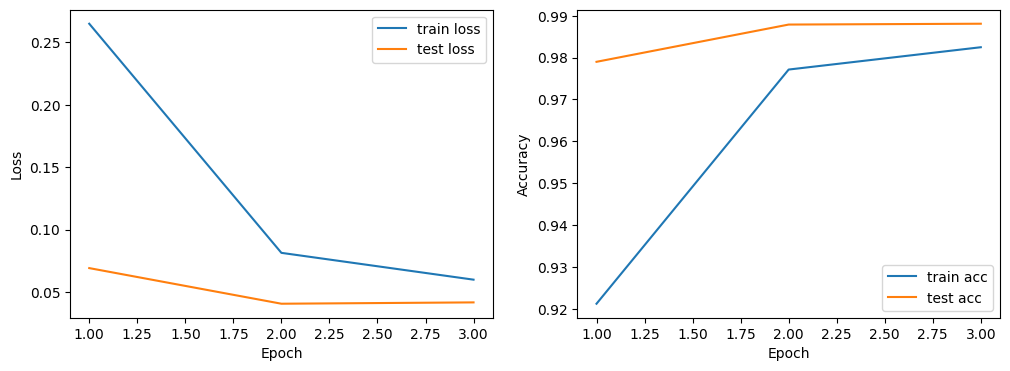

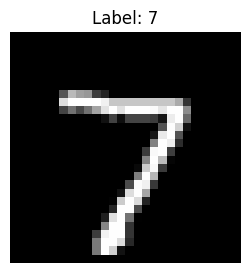

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [11]:

# Example: Train MNIST CNN for a few epochs (set epochs small for quick runs)
mnist_train_loader, mnist_test_loader = get_mnist_loaders(batch_size=256)
model = MNIST_CNN(dropout_p=0.5)
print(model)
model, history = fit_model(model, mnist_train_loader, mnist_test_loader, epochs=3, lr=0.1, momentum=0.95, max_norm=3.0, save_path='./mnist_dropout_checkpoint.pt')
plot_history(history)

# show a sample (2D and interactive 3D)
sample, label = next(iter(mnist_test_loader))
# show 2D sample (ensure tensor is on CPU before plotting)
show_sample_2d(sample[0].cpu(), label=label[0].item())
show_sample_3d_plotly(sample[0], title=f"MNIST digit (label {label[0].item()})")


In [ ]:

Optional: Train on CIFAR-10 (uncomment and run if you want)
Use a different learning rate and epochs for CIFAR; this is a larger dataset.
cifar_train_loader, cifar_test_loader = get_cifar10_loaders(batch_size=128)
cifar_model = CIFAR_CNN(dropout_p=0.5)
cifar_model, cifar_history = fit_model(cifar_model, cifar_train_loader, cifar_test_loader, epochs=20, lr=0.1, momentum=0.9, max_norm=3.0, save_path='./cifar_dropout_checkpoint.pt')
plot_history(cifar_history)


**Notebook created and saved programmatically.**

You can run the cells above to train and visualize. The notebook file is saved to `/mnt/data/mnist_dropout_full.ipynb`.

Notes:
- If running on CPU, training will be slower. Use a GPU for reasonable training speed.
- The MNIST architecture and hyperparameters (dropout p=0.5 on hidden, SGD lr=0.1, momentum=0.95, max-norm) follow the recommendations in Srivastava et al. 2014.